In [1]:
import os, sys
import numpy as np
import tifffile as tiff
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle

from osgeo import gdal

from scipy.ndimage import uniform_filter

import psutil

def memory_check():
    """
    Print the current memory usage.
    """
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    print(f"Memory usage: {mem:.2f} MB")

def create_geographic_meshgrid(grid_size, corners):
    """
    Create a 2D meshgrid of longitude and latitude based on tilted corner points.

    Parameters:
        grid_size (tuple): Number of rows and columns in the grid (rows, cols).
        corners (dict): Dictionary containing the corner points with keys:
                        'down_left', 'up_left', 'up_right', 'down_right'.
                        Each value is a tuple or list [lat, lon].

    Returns:
        tuple: 2D meshgrid arrays of latitudes and longitudes.
    """
    rows, cols = grid_size

    # Extract the corner points
    down_left = np.array(corners['down_left'])
    up_left = np.array(corners['up_left'])
    up_right = np.array(corners['up_right'])
    down_right = np.array(corners['down_right'])

    # Interpolate latitude and longitude along the edges
    left_edge = np.linspace(down_left, up_left, rows)  # Vertical interpolation on left
    right_edge = np.linspace(down_right, up_right, rows)  # Vertical interpolation on right

    # Interpolate across each row
    lat_mesh = np.zeros((rows, cols))
    lon_mesh = np.zeros((rows, cols))
    for i in range(rows):
        # Horizontal interpolation for each row
        row_points = np.linspace(left_edge[i], right_edge[i], cols)
        lat_mesh[i, :] = row_points[:, 0]
        lon_mesh[i, :] = row_points[:, 1]

    return lat_mesh, lon_mesh

def create_xarray_from_grid(data_array, lat_mesh, lon_mesh):
    """
    Create an xarray.Dataset from a 2D numpy array and grid coordinates.

    Parameters:
        data_array (np.ndarray): 2D numpy array of data values.
        lat_mesh (np.ndarray): 2D numpy array of latitude values.
        lon_mesh (np.ndarray): 2D numpy array of longitude values.

    Returns:
        xarray.Dataset: Dataset containing the data and coordinates.
    """
    # Check dimensions
    assert data_array.shape == lat_mesh.shape == lon_mesh.shape, "Array shapes must match!"

    # Define the dataset
    ds = xr.Dataset(
        {
            "data": (["y", "x"], data_array)
        },
        coords={
            "latitude": (["y", "x"], lat_mesh),
            "longitude": (["y", "x"], lon_mesh)
        }
    )
    
    return ds


def load_sar_data(file_path, plot=False, xslice=slice(None), yslice=slice(None)):
    """
    Load SAR complex data from a file and optionally plot magnitude and angle.

    Parameters:
        file_path (str): Path to the SAR data file.
        plot (bool): Whether to plot the magnitude and angle side by side.

    Returns:
        complex ndarray: The loaded SAR complex data.
    """
    try:
        # Open the file with GDAL
        dataset = gdal.Open(file_path, gdal.GA_ReadOnly)
        if dataset is None:
            raise FileNotFoundError(f"Could not open {file_path}")
        
        # Read the raster band
        band = dataset.GetRasterBand(1)
        data = band.ReadAsArray()

        # Convert to complex data if needed
        if band.DataType in [gdal.GDT_CFloat32, gdal.GDT_CFloat64]:
            # Assuming it's already stored as complex
            complex_data = data
        else:
            # Handle cases where real and imaginary are separate (unlikely here)
            raise ValueError("Unexpected data format; complex type expected.")
        
        complex_data = complex_data[xslice, yslice]



        # Plot magnitude and angle if requested
        if plot:
            magnitude = np.abs(complex_data)
            angle = np.angle(complex_data)

            # Percentile scaling for visualization
            lower = np.percentile(magnitude, 2)
            upper = np.percentile(magnitude, 98)

            # Side-by-side plot
            fig, axs = plt.subplots(1, 2, figsize=(15, 6))
            
            # Magnitude plot
            im0 = axs[0].imshow(magnitude, cmap='gray', vmin=lower, vmax=upper)
            axs[0].set_title("Magnitude")
            axs[0].set_xlabel("Range")
            axs[0].set_ylabel("Azimuth")
            fig.colorbar(im0, ax=axs[0], label="Magnitude")

            # Angle plot
            im1 = axs[1].imshow(angle, cmap='hsv')
            axs[1].set_title("Angle")
            axs[1].set_xlabel("Range")
            fig.colorbar(im1, ax=axs[1], label="Angle (Radians)")

            plt.tight_layout()
            plt.show()

        return complex_data
    
    except Exception as e:
        print(f"Error: {e}")
        return None
    
def compute_pauli_vector(HH, HV, VH, VV):
    """
    Compute the Pauli vector representation using the provided polarimetric channels.

    Parameters:
        HH (np.ndarray): HH polarization complex data.
        HV (np.ndarray): HV polarization complex data.
        VH (np.ndarray): VH polarization complex data.
        VV (np.ndarray): VV polarization complex data.

    Returns:
        np.ndarray: 3xHxW Pauli vector.
    """
    # Pauli vector components
    pauli_1 = (HH + VV) / np.sqrt(2)
    pauli_2 = (HH - VV) / np.sqrt(2)
    pauli_3 = (HV + VH) / np.sqrt(2)

    print("Pauli vector computed")
    
    return np.stack([pauli_1, pauli_2, pauli_3], axis=0)

def compute_coherence_matrix(pauli_vector, window_size, block_size):
    """
    Compute the coherence matrix by processing block-by-block with neighborhood averaging.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window.
        block_size (int): Size of the processing blocks.

    Returns:
        np.ndarray: Coherence matrix with shape (3, 3, H, W).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = np.zeros((3, 3, H, W), dtype=np.complex64)
    pad_size = window_size // 2

    # Pad the Pauli vector to handle edge effects
    padded_pauli_vector = np.pad(pauli_vector, ((0, 0), (pad_size, pad_size), (pad_size, pad_size)), mode='reflect')

    for row_start in range(0, H, block_size):
        for col_start in range(0, W, block_size):
            row_end = min(row_start + block_size, H)
            col_end = min(col_start + block_size, W)

            # Add padding to the block for neighborhood filtering
            padded_row_start = row_start + pad_size
            padded_col_start = col_start + pad_size
            padded_row_end = row_end + pad_size
            padded_col_end = col_end + pad_size

            block = padded_pauli_vector[:, padded_row_start - pad_size:padded_row_end + pad_size,
                                        padded_col_start - pad_size:padded_col_end + pad_size]

            block_coherence = np.zeros((3, 3, block.shape[1] - 2 * pad_size, block.shape[2] - 2 * pad_size), dtype=np.complex64)

            # Compute block coherence matrix
            for i in range(3):
                for j in range(3):
                    block_coherence_full = block[i] * np.conj(block[j])

                    # Apply neighborhood averaging
                    block_coherence_avg = uniform_filter(block_coherence_full.real, size=window_size) + \
                                          1j * uniform_filter(block_coherence_full.imag, size=window_size)

                    # Trim the padding
                    block_coherence[i, j] = block_coherence_avg[pad_size:-pad_size, pad_size:-pad_size]

            # Assign back to the global coherence matrix
            coherence_matrix[:, :, row_start:row_end, col_start:col_end] = block_coherence

    print("Coherence_matrix computed")

    return coherence_matrix

def cloude_pottier_decomposition(pauli_vector, reference_vector, window_size=3, block_size=10):
    """
    Perform Cloude-Pottier decomposition to compute entropy, alpha angle, and classify land types.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window for the coherence matrix.
        block_size (int): Size of the processing blocks.

    Returns:
        tuple: Entropy (H), Alpha angle (alpha), and land type classification (Z).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = compute_coherence_matrix(pauli_vector, window_size, block_size)

    entropy = np.zeros((H, W))
    alpha = np.zeros((H, W))
    Z = np.zeros((H, W), dtype=np.uint8)

    # reference_vector = np.array([0, 0, 1], dtype=np.complex64)

    for i in range(H):
        print(f"Row: {i}")
        memory_check()
        for j in range(W):
            local_matrix = coherence_matrix[:, :, i, j]

            # Eigenvalue decomposition
            eigvals, eigvecs = np.linalg.eigh(local_matrix)
            eigvals = np.abs(eigvals)
            eigvals /= np.sum(eigvals)

            # Calculate entropy and alpha
            entropy[i, j] = -np.sum(eigvals * np.log(eigvals + 1e-10))

            # #Compute the mean alpha
            
            angles = np.arccos(np.clip(np.abs(np.dot(eigvecs.T, reference_vector)), 0, 1))
            angles_degrees = angles * (180 / np.pi)
            alpha[i, j] = np.sum(eigvals * angles_degrees)

            # angles = np.arccos(np.clip(np.abs(eigvecs[0, :]), 0, 1))  # Angles with reference [1, 0, 0] by default
            # angles_degrees = angles * (180 / np.pi)
            # alpha[i, j] = np.sum(eigvals * angles_degrees)

            # Land type classification
            if entropy[i, j] >= 0.9 and alpha[i, j] >= 55:
                Z[i, j] = 1  # Z1: Forest and canopy structures
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 42:
                Z[i, j] = 2  # Z2: Cloud
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 40:
                Z[i, j] = 3  # Z3: Not possible region
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 50:
                Z[i, j] = 4  # Z4: Forestry or double bounce
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 40:
                Z[i, j] = 5  # Z5: Vegetation
            elif entropy[i, j] >= 0.5 and alpha[i, j] < 40:
                Z[i, j] = 6  # Z6: Random surface propagation
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 48:
                Z[i, j] = 7  # Z7: Dihedral scatterer
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 42:
                Z[i, j] = 8  # Z8: Dipole
            elif entropy[i, j] < 0.5 and alpha[i, j] < 42:
                Z[i, j] = 9  # Z9: X-Bragg surface
            else:
                ValueError("alpha / entropy values are not valid")

    print("cloude_pottier_decomposition")

    return entropy, alpha, Z

def calculate_land_type_percentages(Z, land_cover_classes):
    """
    Calculate the percentage of each land type in the classification map,
    ensuring all predefined classes are included, even if absent.

    Parameters:
        Z (np.ndarray): Land type classification map.
        land_cover_classes (dict): Dictionary of land cover classes with their labels.

    Returns:
        dict: Dictionary with land type values as keys and their percentages as values.
    """
    # Flatten the array and count unique values
    unique_values, counts = np.unique(Z, return_counts=True)
    total_pixels = Z.size

    # Calculate percentages only for values present in Z
    percentages = {int(value): (count / total_pixels) * 100 for value, count in zip(unique_values, counts)}

    # Ensure all land cover classes are included, even if absent
    all_percentages = {key: percentages.get(key, 0) for key in land_cover_classes.keys()}

    return all_percentages


# def plot_land_classification(Z, labels, colors):
#     """
#     Plot the land type classification with labeled regions, colors, and percentages.

#     Parameters:
#         Z (np.ndarray): Land type classification map.
#         labels (dict): Dictionary of land type values and their descriptions.
#         colors (dict): Dictionary of land type values and their corresponding colors.

#     Returns:
#         None
#     """
#     from matplotlib.colors import ListedColormap, BoundaryNorm
#     import matplotlib.pyplot as plt
#     import numpy as np
#     from matplotlib.patches import Rectangle

#     # Ensure the colormap matches the numeric keys in `labels`
#     sorted_keys = list(labels.keys())  # Ensure keys are sorted in the same order
#     color_list = [colors[key] for key in sorted_keys]
#     cmap = ListedColormap(color_list)

#     # Calculate percentages using the helper function
#     percentages = calculate_land_type_percentages(Z, labels)

#     # Adjust the figure size and layout
#     fig, ax = plt.subplots(figsize=(12, 8))  # Widen figure for better alignment
#     im = plt.imshow(Z, cmap=cmap)
#     plt.title("Land Type Classification", fontsize=14)
#     plt.axis("off")

#     # Add a colorbar for clarity
#     cbar = plt.colorbar(im, ax=ax, ticks=np.arange(len(sorted_keys)))
#     cbar.set_ticklabels([labels[key] for key in sorted_keys])

#     # Define positions for legend
#     legend_x_start = 0.8  # Adjust horizontal position of legend
#     legend_y_start = 0.9  # Adjust vertical position of legend
#     box_size = 0.03  # Size of the color boxes

#     fig.text(legend_x_start, legend_y_start, "Land Type Legend:", fontsize=12, weight='bold', ha='left')

#     for i, key in enumerate(sorted_keys):
#         label = labels[key]
#         percentage_text = f"{percentages.get(key, 0):.2f}%"

#         # Add a colored rectangle with a black border
#         fig.patches.append(Rectangle(
#             (legend_x_start - 0.04, legend_y_start - i * (box_size + 0.02)),  # Rectangle position
#             box_size, box_size, linewidth=1, edgecolor="black", facecolor=colors[key],
#             transform=fig.transFigure, clip_on=False
#         ))

#         # Add text aligned next to the rectangle
#         fig.text(legend_x_start, legend_y_start - i * (box_size + 0.02) + box_size / 4,
#                  f"{label} ({percentage_text})", fontsize=10, ha='left', va='center')

#     # Adjust spacing for better alignment
#     plt.subplots_adjust(left=0.05, right=0.75, top=0.95, bottom=0.05)
#     plt.show()



# def plot_land_classification(Z):
#     """
#     Plot the land type classification with labeled regions.

#     Parameters:
#         Z (np.ndarray): Land type classification map.

#     Returns:
#         None
#     """
#     # Define a colormap and labels for the land types
#     cmap = plt.cm.get_cmap('tab10', 9)
#     labels = [
#         "Z1: Forest and canopy structures",
#         "Z2: Cloud",
#         "Z3: Not possible region",
#         "Z4: Forestry or double bounce",
#         "Z5: Vegetation",
#         "Z6: Random surface propagation",
#         "Z7: Dihedral scatterer",
#         "Z8: Dipole",
#         "Z9: X-Bragg surface"
#     ]

#     plt.figure(figsize=(10, 8))
#     plt.imshow(Z, cmap=cmap, vmin=1, vmax=9)
#     plt.colorbar(ticks=np.arange(1, 10), label="Land Type")

#     # Add labels as text
#     for i, label in enumerate(labels, start=1):
#         plt.text(0, -i * 0.1, label, fontsize=10, transform=plt.gca().transAxes)

#     plt.title("Land Type Classification")
#     plt.axis("off")

# def plot_land_classification(Z):
#     """
#     Plot the land type classification with labeled regions.

#     Parameters:
#         Z (np.ndarray): Land type classification map.

#     Returns:
#         None
#     """
#     # Define a custom colormap for better representation
#     colors = [
#         "#228B22",  # Forest and canopy structures (green)
#         "#ADD8E6",  # Cloud (light blue)
#         "#808080",  # Not possible region (gray)
#         "#8B0000",  # Forestry or double bounce (dark red)
#         "#FFFF00",  # Vegetation (yellow)
#         "#D3D3D3",  # Random surface propagation (light gray)
#         "#0000FF",  # Dihedral scatterer (blue)
#         "#FFA500",  # Dipole (orange)
#         "#FFFFFF",  # X-Bragg surface (white)
#     ]
#     cmap = ListedColormap(colors)

#     labels = [
#         "Z1: Forest and canopy structures",
#         "Z2: Cloud",
#         "Z3: Not possible region",
#         "Z4: Forestry or double bounce",
#         "Z5: Vegetation",
#         "Z6: Random surface propagation",
#         "Z7: Dihedral scatterer",
#         "Z8: Dipole",
#         "Z9: X-Bragg surface"
#     ]

#     plt.figure(figsize=(10, 8))
#     plt.imshow(Z, cmap=cmap, vmin=1, vmax=9)
#     cbar = plt.colorbar(ticks=np.arange(1, 10), label="Land Type")
#     cbar.ax.set_yticklabels(labels)

#     plt.title("Land Type Classification")
#     plt.axis("off")
#     plt.show()


def plot_land_classification(Z, labels, colors):
    """
    Plot the land type classification with labeled regions, colors, and percentages.

    Parameters:
        Z (np.ndarray): Land type classification map.
        labels (dict): Dictionary of land type values and their descriptions.
        colors (dict): Dictionary of land type values and their corresponding colors.

    Returns:
        None
    """

    # Create a sorted list of unique values to handle missing classes in Z
    sorted_keys = list(labels.keys())

    # Create a colormap that corresponds to all defined keys
    color_list = [colors[key] for key in sorted_keys]
    cmap = ListedColormap(color_list)
    norm = BoundaryNorm(sorted_keys + [max(sorted_keys) + 1], cmap.N)

    # Calculate percentages using the helper function
    percentages = calculate_land_type_percentages(Z, labels)

    # Adjust the figure size and layout
    fig, ax = plt.subplots(figsize=(12, 8))  # Widen figure for better alignment
    im = plt.imshow(Z, cmap=cmap, norm=norm)
    plt.title("Land Type Classification", fontsize=14)
    plt.axis("off")

    # Define positions for legend
    legend_x_start = 0.8  # Adjust horizontal position of legend
    legend_y_start = 0.9  # Adjust vertical position of legend
    box_size = 0.03  # Size of the color boxes

    fig.text(legend_x_start, legend_y_start, "Land Type Legend:", fontsize=12, weight='bold', ha='left')
    legend_y_start -= (box_size + 0.04)

    for i, key in enumerate(sorted_keys):
        label = labels[key]
        percentage_text = f"{percentages.get(key, 0):.2f}%"

        # Add a colored rectangle with a black border
        fig.patches.append(Rectangle(
            (legend_x_start - 0.04, legend_y_start - i * (box_size + 0.02)),  # Rectangle position
            box_size, box_size, linewidth=1, edgecolor="black", facecolor=colors[key],
            transform=fig.transFigure, clip_on=False
        ))

        # Add text aligned next to the rectangle
        fig.text(legend_x_start, legend_y_start - i * (box_size + 0.02) + box_size / 4,
                 f"{label} ({percentage_text})", fontsize=10, ha='left', va='center')

    # Adjust spacing for better alignment
    plt.subplots_adjust(left=0.05, right=0.75, top=0.95, bottom=0.05)
    plt.show()


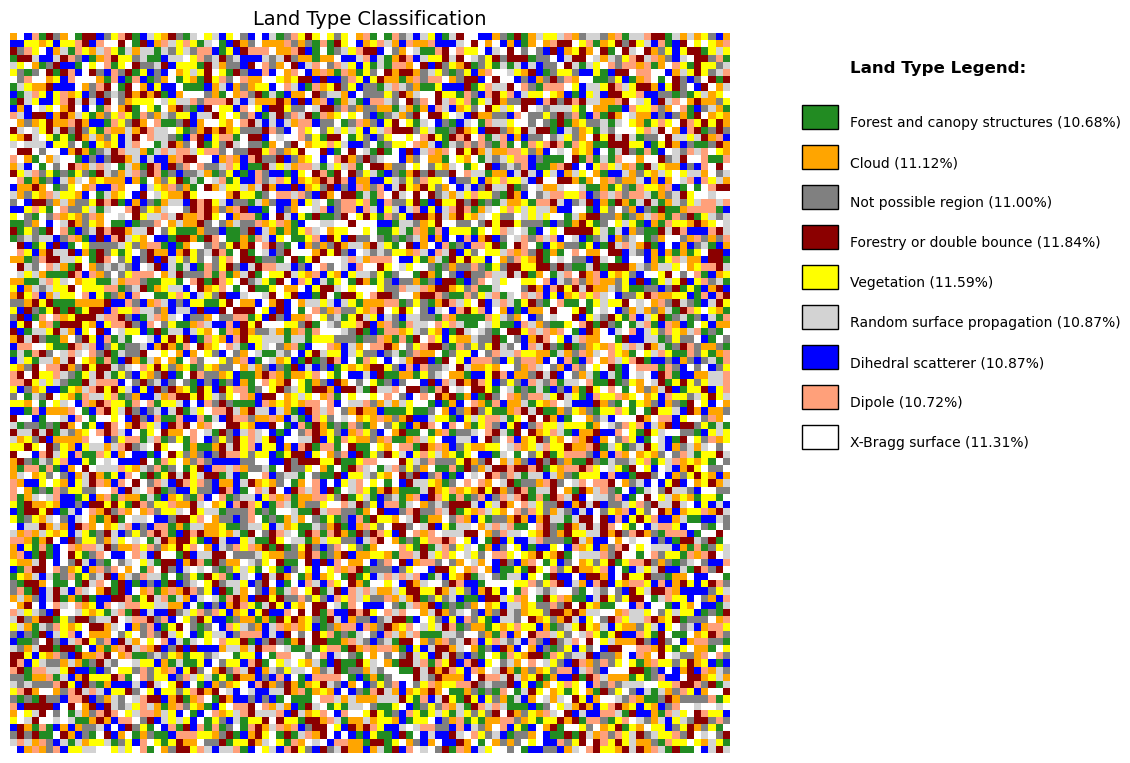

In [42]:

# Example land type map
Z = np.random.randint(1, 10, size=(100, 100))

# Call the plot function

# Define a custom colormap for the land types
colors = {
    1: "#228B22",  # Z1: Forest and canopy structures
    2: "#FFA500",  # Z2: Cloud
    3: "#808080",  # Z3: Not possible region
    4: "#8B0000",  # Z4: Forestry or double bounce
    5: "#FFFF00",  # Z5: Vegetation
    6: "#D3D3D3",  # Z6: Random surface propagation
    7: "#0000FF",  # Z7: Dihedral scatterer
    8: "#FFA07A",  # Z8: Dipole
    9: "#FFFFFF",  # Z9: X-Bragg surface
}

labels = {
    1: "Forest and canopy structures",
    2: "Cloud",
    3: "Not possible region",
    4: "Forestry or double bounce",
    5: "Vegetation",
    6: "Random surface propagation",
    7: "Dihedral scatterer",
    8: "Dipole",
    9: "X-Bragg surface"
}

plot_land_classification(Z, labels, colors)

esa_img shape: (1236, 932)
[10. 20. 30. 40. 50. 60. 80. 90. nan]
dict_keys([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100])


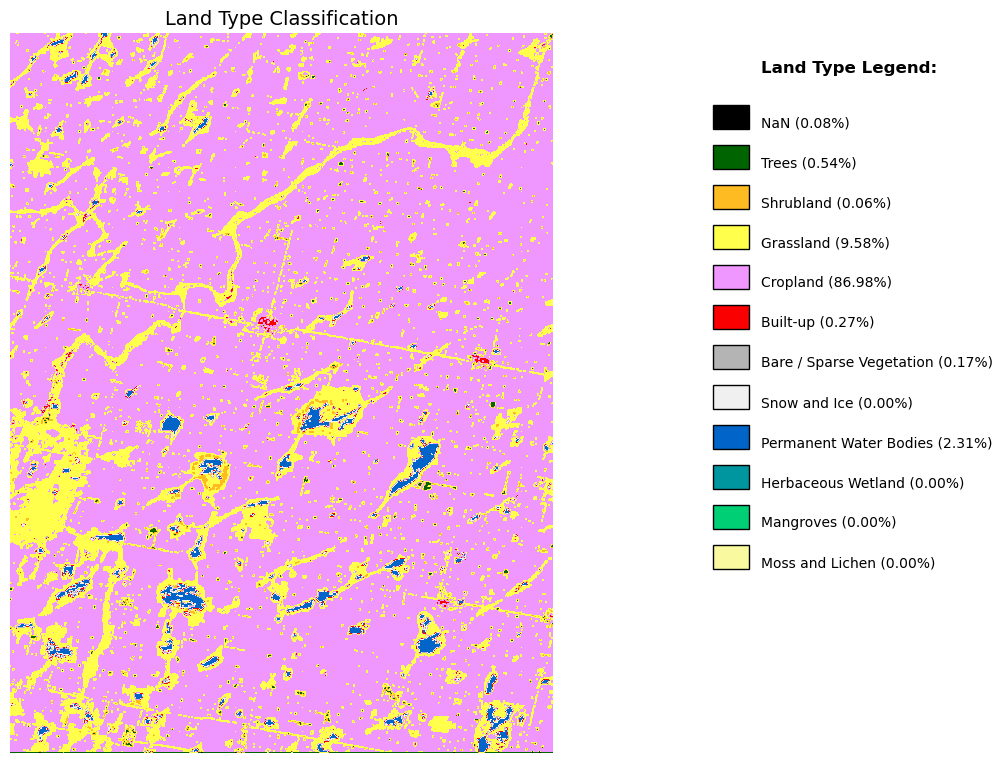

In [38]:
base_dir = "/home/renaud/Data/polarimetric_data/"
esa_path = os.path.join(base_dir, "SatSao_MonteMaiz_cordoba", "ESA_LandCover.tif")
esa_img = tiff.imread(esa_path)
print(f"esa_img shape: {esa_img.shape}")
print(np.unique(esa_img))
esa_img_no_nan = np.nan_to_num(esa_img, nan=0)

# Define land cover classes and their colors
land_cover_classes = {
    0: "NaN",
    10: "Trees",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare / Sparse Vegetation",
    70: "Snow and Ice",
    80: "Permanent Water Bodies",
    90: "Herbaceous Wetland",
    95: "Mangroves",
    100: "Moss and Lichen"
}

colors = {
    0: "#000000",  #"Nan"
    10: "#006400",  # Trees
    20: "#ffbb22",  # Shrubland
    30: "#ffff4c",  # Grassland
    40: "#f096ff",  # Cropland
    50: "#fa0000",  # Built-up
    60: "#b4b4b4",  # Bare/Sparse
    70: "#f0f0f0",  # Snow/Ice
    80: "#0064c8",  # Water
    90: "#0096a0",  # Wetland
    95: "#00cf75",  # Mangroves
    100: "#f9f9a0",  # Moss/Lichen
}

# Plot the land cover image
print(land_cover_classes.keys())
plot_land_classification(esa_img_no_nan, land_cover_classes, colors)

/home/renaud/miniforge3/envs/claymodel/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


(0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


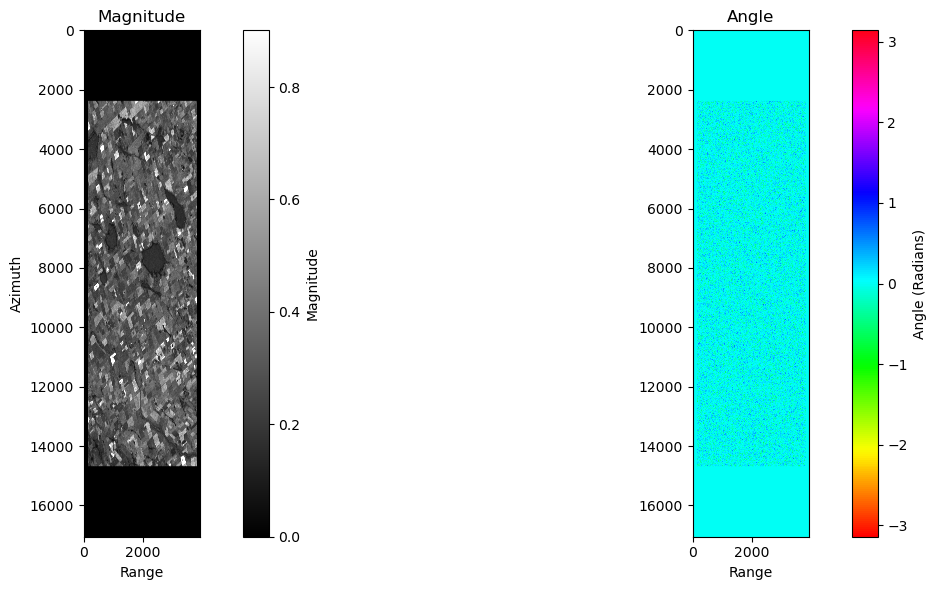

(0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
(0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.

In [ ]:
# Define the base path and file paths for polarization data
base_path = "/home/renaud/Data/polarimetric_data/SatSao_MonteMaiz_cordoba/S1A_OPER_SAR_EOSSP__CORE_L1A_OLVF_20200703T145917/Data"

hh_image_file = os.path.join(base_path, "slc-acqId0000011802-a-sm6-0000000000-s6qp-hh")
hv_image_file = os.path.join(base_path, "slc-acqId0000011802-a-sm6-0000000000-s6qp-hv")
vh_image_file = os.path.join(base_path, "slc-acqId0000011802-a-sm6-0000000000-s6qp-vh")
vv_image_file = os.path.join(base_path, "slc-acqId0000011802-a-sm6-0000000000-s6qp-vv")

# Select data subset
# xslice = slice(8000, 8500)
# yslice = slice(2000, 2500)  

xslice = slice(None)
yslice = slice(None)

plot = True

# Example usage: Load and plot HH data
hh_data = load_sar_data(hh_image_file, plot, xslice, yslice)

# Load HV, VH, and VV data without plotting
plot = False

hv_data = load_sar_data(hv_image_file, plot, xslice, yslice)
vh_data = load_sar_data(vh_image_file, plot, xslice, yslice)
vv_data = load_sar_data(vv_image_file, plot, xslice, yslice)

pauli_vector = compute_pauli_vector(hh_data, hv_data, vh_data, vv_data)
reference_vector = np.array([1, 0, 0], dtype=np.complex64)
entropy, alpha, Z = cloude_pottier_decomposition(pauli_vector, reference_vector,  window_size=5, block_size=256)
plot_land_classification(Z)

/home/renaud/miniforge3/envs/claymodel/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


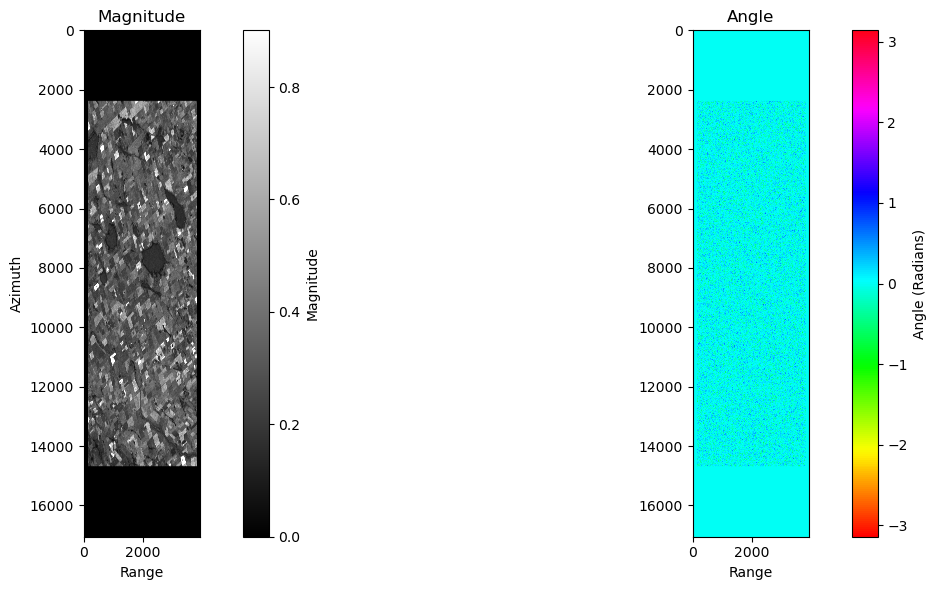

In [3]:

# Load the SatSao data
base_path = "/home/renaud/Data/polarimetric_data/SatSao_MonteMaiz_cordoba/S1A_OPER_SAR_EOSSP__CORE_L1A_OLVF_20200703T145917/Data"
hh_image_file = os.path.join(base_path, "slc-acqId0000011802-a-sm6-0000000000-s6qp-hh")
hh_data = load_sar_data(hh_image_file, True)

hh_array = abs(hh_data)  # Take the magnitude

# Define the corners
corner_points = {
    "down_left": [-33.6022342842935, -62.6629033914949],
    "up_left": [-33.0067016645971, -62.8387399200105],
    "up_right": [-32.936870128906, -62.5155618487516],
    "down_right": [-33.5319201504333, -62.3371495659001]
}

# Define grid size
grid_size = hh_array.shape

# Create the meshgrid
latitude_mesh, longitude_mesh = create_geographic_meshgrid(grid_size, corner_points)

# Create the xarray.Dataset
hh_xarray = create_xarray_from_grid(hh_array, latitude_mesh, longitude_mesh)
# print(dataset)
# dataset.data.isel(x=slice(1000, 3000), y=slice(5000, 7000)).plot()

# Save xarray.DataArray or xarray.Dataset to NetCDF
hh_xarray.to_netcdf("/home/renaud/Data/polarimetric_data/SatSao_MonteMaiz_cordoba/hh_xarray.nc")

# # Percentile scaling for visualization
# lower = np.percentile(hh_xarray, 2)
# upper = np.percentile(hh_xarray, 98)
# plt.imshow(hh_xarray, vmin=lower, vmax=upper)
# plt.imshow(latitude_mesh)
# plt.imshow(longitude_mesh)

esa_img shape: (1236, 932)


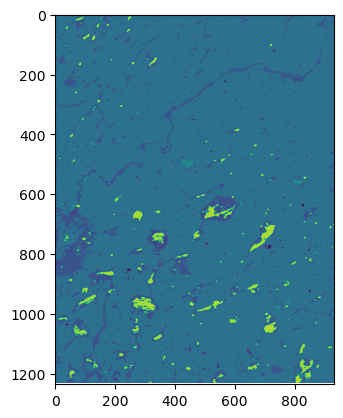

In [4]:
import tifffile as tiff

base_dir = "/home/renaud/Data/polarimetric_data"
os.chdir(base_dir)

esa_path = os.path.join(base_dir, "SatSao_MonteMaiz_cordoba", "ESA_LandCover.tif")
esa_img = tiff.imread(esa_path)
print(f"esa_img shape: {esa_img.shape}")
plt.imshow(esa_img)

# Define the corners
corner_points = {
    "down_left": [-62.8387399200105, -33.6022342842935],
    "up_left": [-62.3371495659001, -33.6022342842935],
    "up_right": [-62.3371495659001, -32.936870128906],
    "down_right": [-62.8387399200105, -32.936870128906]
}

# Define grid size
grid_size = esa_img.shape

# Create the meshgrid
latitude_mesh, longitude_mesh = create_geographic_meshgrid(grid_size, corner_points)

# Create the xarray.Dataset
esa_xarray = create_xarray_from_grid(esa_img, latitude_mesh, longitude_mesh)
# print(dataset)
# dataset.data.isel(x=slice(1000, 3000), y=slice(5000, 7000)).plot()

# Save xarray.DataArray or xarray.Dataset to NetCDF
esa_xarray.to_netcdf("/home/renaud/Data/polarimetric_data/SatSao_MonteMaiz_cordoba/esa_xarray.nc")

In [6]:
print(hh_array.shape)
print(esa_img.shape)


(17053, 3929)
(1236, 932)
